In [222]:
from lib.main_func_p1 import path, timer
import pandas as pd
from importlib import reload
from collections import OrderedDict
import lib.main_func_p4
from lib.main_func_p4 import modelXGBoost_fit_scores


#XGBoost library
import xgboost as xgb


In [223]:
# proteina (uniprot_ID)
uniprot_id = 'P56817'
excel_name = 'P56817_20220603133435_top_scores_XGBClassifier_jaccard_rf4'
path_file = path(uniprot_id)
# Parametros
seed = 142857
fp_name = 'morgan2_c'

In [224]:
# Load top_scores
top_scores = pd.read_excel(f'./top_scores/{excel_name}.xlsx')

# Best calibration scores
top_socres_len = 15
top_scores_top = top_scores.iloc[:top_socres_len]
top_scores_top_index_list = top_scores_top.index
top_scores.head()

,model,params_dict,AUC_train,AUC_valid,accuracy_train,accuracy_valid,recall_train,recall_valid,specificity_train,specificity_valid,precision_train,precision_valid,f1_score_train,f1_score_valid,conf_matrix_train,conf_matrix_valid,calibration_score
0,modelID_435,"OrderedDict([('alpha', 0.2), ('gamma', 0.0), (...",0.995,0.958,0.985,0.942,0.996,0.985,0.917,0.678,0.987,0.949,0.985,0.938,"[[624, 55], [18, 4150]]","[[81, 39], [11, 725]]",0.012394
1,modelID_185,"OrderedDict([('alpha', 0.0), ('gamma', 0.0), (...",0.996,0.962,0.985,0.949,0.996,0.989,0.917,0.704,0.987,0.953,0.985,0.946,"[[623, 56], [17, 4151]]","[[84, 36], [8, 728]]",0.012544
2,modelID_379,"OrderedDict([('alpha', 0.2), ('gamma', 0.3), (...",0.996,0.958,0.984,0.939,0.997,0.984,0.904,0.663,0.985,0.948,0.984,0.936,"[[616, 63], [13, 4155]]","[[80, 40], [12, 724]]",0.012689
3,modelID_328,"OrderedDict([('alpha', 0.3), ('gamma', 0.0), (...",0.996,0.955,0.986,0.943,0.996,0.985,0.925,0.685,0.987,0.950,0.985,0.940,"[[626, 53], [17, 4151]]","[[82, 38], [11, 725]]",0.012720
4,modelID_235,"OrderedDict([('alpha', 0.2), ('gamma', 0.0), (...",0.995,0.958,0.984,0.939,0.996,0.984,0.910,0.663,0.986,0.948,0.984,0.936,"[[619, 60], [18, 4150]]","[[80, 40], [12, 724]]",0.012913


In [225]:
reload(lib.main_func_p4)
from lib.main_func_p4 import modelXGBoost_fit_scores

resample_factor = int(str.split(excel_name,'_')[-1][2:])

# Load train and validation datasets
df_train = pd.read_pickle(f'{path_file}_dataset_train')
df_valid = pd.read_pickle(f'{path_file}_dataset_valid')

new_row_list = list()
results_ROF_list_train = list()
results_ROF_list_valid = list()
df_list = list()
plots_name_list = list()

for i, params_dict in enumerate(top_scores.params_dict.iloc[0:top_socres_len]):
    eval_metric = ['error', 'auc']
    tick = timer()
    params_dict_Orderer = params_dict
    params_dict = dict(eval(params_dict))
    default_params_xgb = {'booster': 'gbtree', 'tree_method': 'gpu_hist',
                          'objective':'binary:logistic', 'grow_policy': 'depthwise',
                          'eval_metric': eval_metric, 'early_stopping_rounds':10}
    params_dict.update(default_params_xgb)


    xgb_clf = xgb.XGBClassifier(**params_dict)

    # Train model and evaluating scores (train / validation)
    xgb_clf, scores_train, scores_valid = modelXGBoost_fit_scores(xgb_clf, fp_name, df_train, df_valid,
                                                                  resample_factor=resample_factor,
                                                                  resample_mode='under_sampling')

    if i == 0:
        xgb_clf.save_model(f'./models/{uniprot_id}_model.ubj')
        print(f'Best model saved ({top_scores.model.iloc[i]})')

    # ROF results
    results_ROF_list_train.append(scores_train[7])
    results_ROF_list_valid.append(scores_valid[7])

    # save pred and pred_prob of train set
    df = df_train[['activity', 'prediction', 'prediction_prob']].copy()
    df_list.append(df)

    plots_name_list.append(top_scores.model.iloc[i])
    print(f'{i+1}/{top_socres_len}. {top_scores.model.iloc[i]}. AUC_socre=(train={scores_train[0]},'
          f' valid={scores_valid[0]}). Time elapsed: {timer(tick)}')

under_sampling - 4: 4847 to 3395
Best model saved (modelID_435)
1/15. modelID_435. AUC_socre=(train=0.989, valid=0.954). Time elapsed: 3.9 seconds.
under_sampling - 4: 4847 to 3395
2/15. modelID_185. AUC_socre=(train=0.987, valid=0.955). Time elapsed: 3.3 seconds.
under_sampling - 4: 4847 to 3395
3/15. modelID_379. AUC_socre=(train=0.99, valid=0.949). Time elapsed: 3.9 seconds.
under_sampling - 4: 4847 to 3395
4/15. modelID_328. AUC_socre=(train=0.989, valid=0.949). Time elapsed: 4.1 seconds.
under_sampling - 4: 4847 to 3395
5/15. modelID_235. AUC_socre=(train=0.992, valid=0.958). Time elapsed: 3.9 seconds.
under_sampling - 4: 4847 to 3395
6/15. modelID_493. AUC_socre=(train=0.991, valid=0.951). Time elapsed: 3.7 seconds.
under_sampling - 4: 4847 to 3395
7/15. modelID_303. AUC_socre=(train=0.988, valid=0.955). Time elapsed: 3.5 seconds.
under_sampling - 4: 4847 to 3395
8/15. modelID_184. AUC_socre=(train=0.99, valid=0.954). Time elapsed: 3.7 seconds.
under_sampling - 4: 4847 to 3395
9/

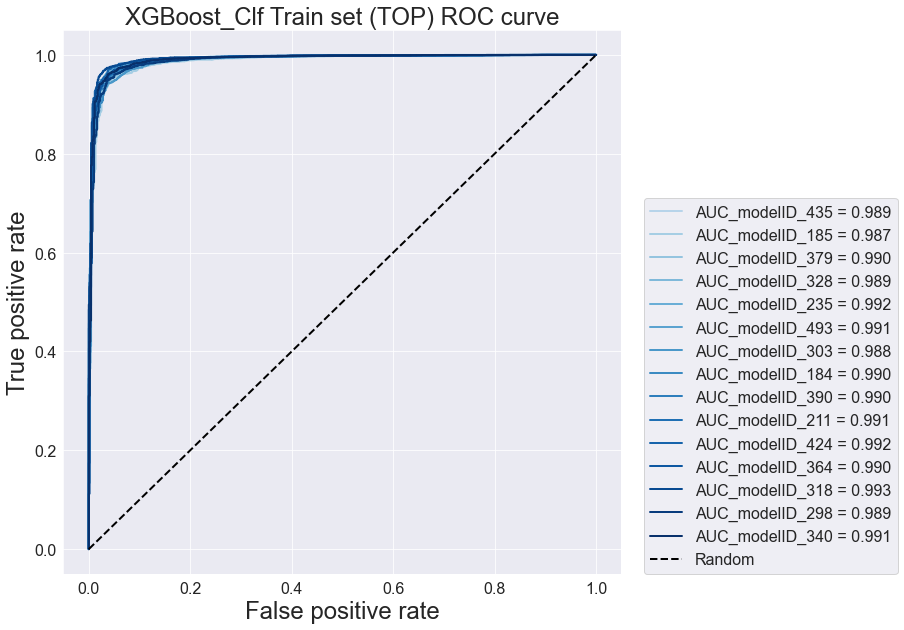

In [226]:
# ROC curve - best scores
reload(lib.main_func_p4)
from lib.main_func_p4 import plot_ROC_curve
results_ROF_train_list_top = list()
results_ROF_valid_list_top = list()
ROC_plots_name_top_name = list()
for i in top_scores_top_index_list:
    results_ROF_train_list_top.append(results_ROF_list_train[i])
    results_ROF_valid_list_top.append(results_ROF_list_valid[i])
    ROC_plots_name_top_name.append(plots_name_list[i])

model_name = f'XGBoost_Clf Train set (TOP)'
plot_ROC_curve(results_ROF_train_list_top, ROC_plots_name_top_name, model_name,
               path_file=path_file, name_mod="train_Top_score", save_fig=True)

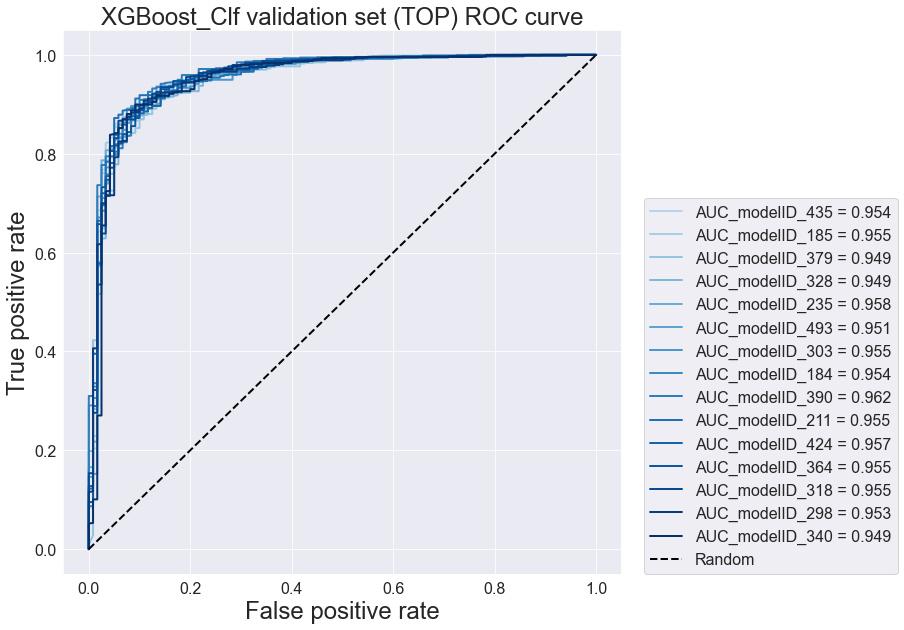

In [227]:
model_name = f'XGBoost_Clf validation set (TOP)'
plot_ROC_curve(results_ROF_valid_list_top, ROC_plots_name_top_name, model_name,
               path_file=path_file, name_mod="validation_Top_score", save_fig=True)

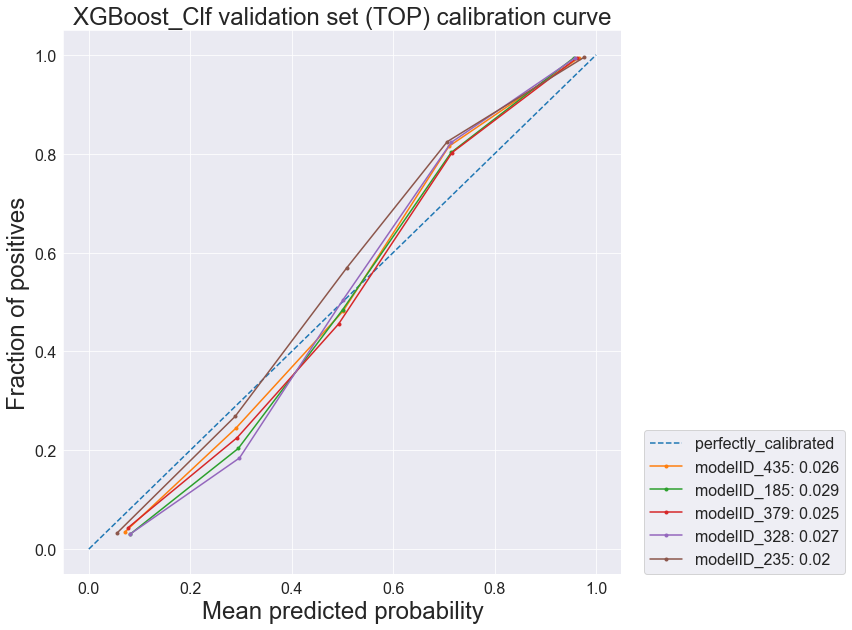

In [228]:
# Calibration curve - best scores (10)
reload(lib.main_func_p4)
from lib.main_func_p4 import plot_calibration_curve
df_list_top = list()
df_list_top_name = list()

# Only graph top 5
for i in top_scores_top_index_list:
    df_list_top.append(df_list[i])
    df_list_top_name.append((plots_name_list[i]))
plot_calibration_curve(df_list_top[:5], df_list_top_name[:5], model_name,
                       path_file=path_file, name_mod="validation_Top_score", save_fig=True)